In [1]:
#|default_exp conv

In [2]:
import sys; sys.path.append('/notebooks')

# Convolutions

In [3]:
#|export
import torch
from torch import nn
from torch.utils.data import default_collate
from typing import Mapping

from miniai.training import * 
from miniai.datasets import * 

In [8]:
import pickle, gzip, math, os, time, shutil
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from torch import tensor
from torch.utils.data import DataLoader
from typing import Mapping
from fastcore.test import test_close
from IPython.core.debugger import set_trace

plt.style.use('grayscale')

torch_device = 'cpu'
device = torch.device(torch_device)


In [29]:
path_data = Path('./data')

In [30]:
path_gz = path_data / 'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

In [31]:
x_imgs = x_train.view(-1, 28, 28)
xv_imgs = x_valid.view(-1, 28, 28)

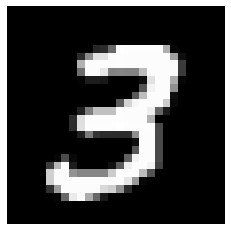

In [32]:
im3 = x_imgs[7]
show_image(im3);

In [33]:
top_edge = tensor([[-1, -1, -1],
                  [0, 0, 0],
                  [1, 1, 1]]).float()

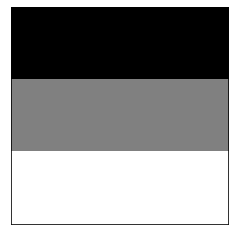

In [34]:
show_image(top_edge, noframe=False);

In [35]:
df = pd.DataFrame(im3[:13,:23])
df.style.format(precision=2).set_properties(**{'font-size': '7pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.17,0.41,1.00,0.99,0.99,0.99,0.99,0.99,0.68,0.02,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.54,0.88,0.88,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.62,0.05
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.70,0.98,0.98,0.98,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.23
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.98,0.98,0.90,0.52,0.52,0.52,0.52,0.74,0.98,0.98,0.98,0.98,0.23
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.11,0.11,0.09,0.00,0.00,0.00,0.00,0.05,0.88,0.98,0.98,0.67,0.03


In [36]:
(im3[3:6,14:17] * top_edge).sum()

tensor(2.9727)

In [37]:
(im3[7:10, 14:17] * top_edge).sum()

tensor(-2.9570)

In [38]:
def apply_kernel(im, row, col, kernel):
    return (im[row-1:row+2,col-1:col+2] * kernel).sum()

In [39]:
apply_kernel(im3, 4, 15, top_edge)

tensor(2.9727)

In [40]:
[[(i,j) for j in range(5)] for i in range(5)]

[[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)],
 [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 0), (3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]]

In [41]:
im3.shape

torch.Size([28, 28])

In [42]:
def conv2d(im, kernel):
    rng = range(1, im.shape[0]-1)
    return tensor([[apply_kernel(im, i, j, kernel) for j in rng] for i in rng])

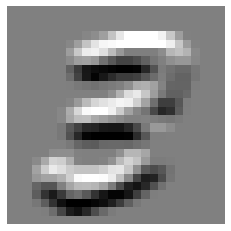

In [43]:
top_edge3 = conv2d(im3, top_edge)
show_image(top_edge3);

In [44]:
left_edge = tensor([[-1, 0, 1],
                   [-1, 0, 1],
                   [-1, 0, 1]]).float()

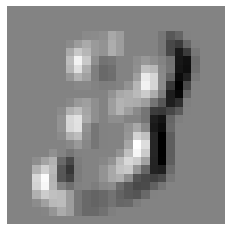

In [45]:
left_edge3 = conv2d(im3, left_edge)
show_image(left_edge3);

## Bonus: im2col

In [22]:
kernel2 = torch.arange(1,5).view(2,2)
kernel2
kernel3 = torch.arange(1,10).view(3,3)
kernel2, kernel3
img = torch.arange(1,17).view(4,4)

In [23]:
# For a 4x4 matrix, kernel3 becomes
kernel = kernel3
flat_img = img.flatten().float()

n = img.shape[0]
k = kernel.shape[0]

result = torch.zeros((n-k+1)**2, n**2)

# 0,0
result[0,   0:k    ]       = kernel[0]
result[0,   n:k  +n]     = kernel[1]
result[0, 2*n:k+2*n] = kernel[2]

# 0,1
result[1,     1:k    +1] = kernel[0]
result[1,   n+1:k  +n+1] = kernel[1]
result[1, 2*n+1:k+2*n+1] = kernel[2]

########

# 1, 0
result[2,   n:k  +  n]   = kernel[0]
result[2, 2*n:k  +2*n]   = kernel[1]
result[2, 3*n:k  +3*n]   = kernel[2]

# 1, 1
result[3,   n+1:k  +n+1] = kernel[0]
result[3, 2*n+1:k+2*n+1] = kernel[1]
result[3, 3*n+1:k+3*n+1] = kernel[2]

#        result[idx, t*n + i*n + j : t*n + i*n + j + k] = kernel[t]
result

tensor([[1., 2., 3., 0., 4., 5., 6., 0., 7., 8., 9., 0., 0., 0., 0., 0.],
        [0., 1., 2., 3., 0., 4., 5., 6., 0., 7., 8., 9., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 2., 3., 0., 4., 5., 6., 0., 7., 8., 9., 0.],
        [0., 0., 0., 0., 0., 1., 2., 3., 0., 4., 5., 6., 0., 7., 8., 9.]])

In [24]:
conv_result = (result @ flat_img).reshape(2,2)
test_close(conv_result, conv2d(img, kernel3))

In [25]:
### Let's refactor it into a loop

# For a 4x4 matrix, kernel3 becomes
kernel = kernel3
flat_img = img.flatten().float()

n = img.shape[0]
k = kernel.shape[0]
dim = n-k+1

new_result = torch.zeros(dim**2, n**2)

for i in range(dim):
    for j in range(dim):
        for t in range(k):
            idx = dim*i + j
            new_result[idx, t*n + i*n + j : t*n + i*n + j + k] = kernel[t]
            
test_close(result, new_result)            

In [96]:
#|export
def im2col(kernel, n, stride=1, device='cpu'):
    """
    Unrolls a square kernel matrix such that when multplied by a flattened image vector, 
    it results in the flattened convolution.
    
    First let's assume stride 1.
    
    Takes a `(k,k)` kernel and a image dimension `n` and turns it into a matrix of dimensions
    `((n-k+1)^2, n^2)`
    """
    k = kernel.shape[0]
    dim = n-k+1
    
    result = torch.zeros(dim**2, n**2).to(device=device)
    for i in range(dim):
        for j in range(dim):
            idx = dim *i + j
            for t in range(k):
                result[idx, t*n + i*n + j : t*n + i*n + j + k] = kernel[t]

    return result

def conv2d_col(img, kernel, device='cpu'):
    n = img.shape[0]
    k = kernel.shape[0]
    kernel_col = im2col(kernel, n, device=device)
    return (kernel_col @ img.view(-1)).view(n-k+1, n-k+1)

In [27]:
test_close(conv2d_col(im3, kernel3), conv2d(im3, kernel3))

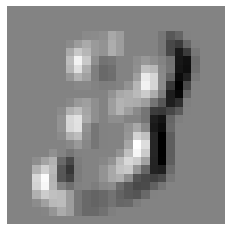

In [28]:
show_image(conv2d_col(im3, left_edge));

In [33]:
%timeit -n 10 _=conv2d_col(im3, left_edge)

18.6 ms ± 3.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
%timeit -n 10 _=conv2d(im3, left_edge)

11.2 ms ± 2.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Does the gpu make a difference?

In [35]:
device='cuda'
im3_g = im3.to(device)
left_edge_g = left_edge.to(device)

In [36]:
%timeit -n 50 _=conv2d_col(im3_g, left_edge_g, device=device)

46.3 ms ± 5.37 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [37]:
%timeit -n 50 _=conv2d(im3_g, left_edge_g)

36.5 ms ± 3.75 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


💩

## Conv size equations

A square image of size $n$ convolved with a kernel of size $k$ with stride $s$ and padding $p$ will yield a square result of side:

$$\frac{n-k+2p+1}{s}$$

## Convolutions in Pytorch

In [55]:
import torch.nn.functional as F
import torch

In [56]:
inp = im3[None, None, :, :].float()
inp_unf = F.unfold(inp, (3, 3))[0]
inp_unf.shape

torch.Size([9, 676])

In [57]:
w = left_edge.view(-1)
w.shape

torch.Size([9])

In [58]:
out_unf = w@inp_unf
out_unf.shape

torch.Size([676])

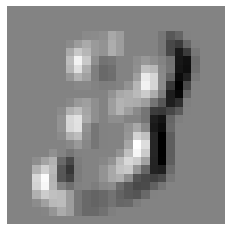

In [59]:
out = out_unf.view(26, 26)
show_image(out);

In [60]:
rng = range(1,27)
%timeit -n 1 tensor([[apply_kernel(im3, i,j,left_edge) for j in rng] for i in rng]);

9.26 ms ± 601 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [61]:
%timeit -n 100 (w@F.unfold(inp, (3,3))[0]).view(26,26);

83.6 µs ± 26.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
%timeit -n 100 F.conv2d(inp, left_edge[None,None])

The slowest run took 8.76 times longer than the fastest. This could mean that an intermediate result is being cached.
61.8 µs ± 75.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
%timeit -n 100 conv2d_col(im3, left_edge) # wow...

24.8 ms ± 3.64 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [62]:
diag1_edge = tensor([[0, -1, 1],
                     [-1, 1, 0],
                     [1, 0, 0]]).float()

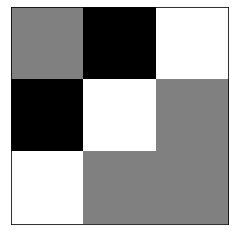

In [63]:
show_image(diag1_edge, noframe=False);

In [64]:
diag2_edge = tensor([[1, -1, 0],
                    [0, 1, -1],
                    [0, 0, 1]]).float()

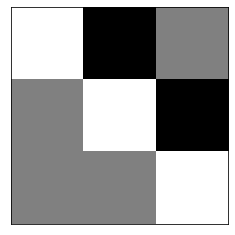

In [65]:
show_image(diag2_edge, noframe=False);

In [66]:
xb = x_imgs[:16][:, None]
xb.shape

torch.Size([16, 1, 28, 28])

In [67]:
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge]).unsqueeze(1)
edge_kernels.shape

torch.Size([4, 1, 3, 3])

In [68]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([16, 4, 26, 26])

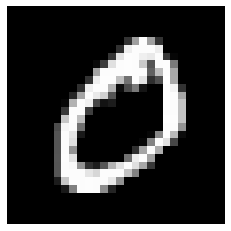

In [69]:
show_image(xb[1]);

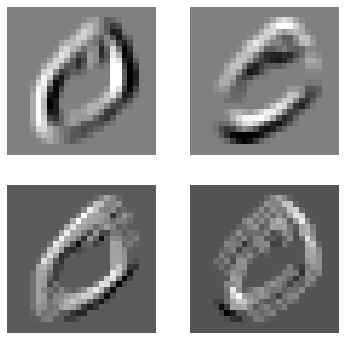

In [70]:
show_images([batch_features[1, i] for i in range(4)])

## Let's make a CNN

In [71]:
n, m = x_train.shape
c = y_train.max() +1
nh = 50

In [72]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
broken_cnn = nn.Sequential(
    nn.Conv2d(1, 30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30, 10, kernel_size=3, padding=1))

In [73]:
broken_cnn(xb).shape

torch.Size([16, 10, 28, 28])

In [5]:
#|export
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [75]:
simple_cnn = nn.Sequential(
    conv(1, 4), # 14x14
    conv(4, 8), # 7x7
    conv(8, 16), # 4x4
    conv(16, 32), # 2x2
    conv(32, 10, act=False), #1x1
    nn.Flatten(),
)

In [76]:
simple_cnn(xb).shape

torch.Size([16, 10])

In [77]:
x_imgs = x_train.view(-1, 1, 28, 28)
xv_imgs = x_valid.view(-1, 1, 28, 28)

In [78]:
train_ds, valid_ds = Dataset(x_imgs, y_train), Dataset(xv_imgs, y_valid)

In [98]:
#|export
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k, v in x.items()}
    return type(x)(to_device(o, device) for o in x)

def collate_device(b): return to_device(default_collate(b))

In [80]:
from torch import optim

bs = 256
lr = 0.4

train_dl, valid_dl = get_dls(train_ds, valid_ds, bs, collate_fn=collate_device)
opt = optim.SGD(simple_cnn.parameters(), lr=lr)

In [81]:
loss, acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

  0%|          | 0/5 [00:00<?, ?it/s]

0 0.3286376799106598 0.9016000008583069
1 0.2072501368522644 0.9362000005722045
2 0.1255029495239258 0.9616000007629395
3 0.1763900450229645 0.9478000000953675
4 0.09630902469158173 0.9713999995231628


In [84]:
opt = optim.SGD(simple_cnn.parameters(), lr=lr/4)
loss, acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

  0%|          | 0/5 [00:00<?, ?it/s]

0 0.0817444613456726 0.9760999995231628
1 0.08409699759483337 0.9752999995231628
2 0.08253622913360596 0.975999999332428
3 0.07882757344245911 0.9773999995231628
4 0.08545005779266357 0.9752999994277954


# Color 

In [85]:
from torchvision.io import read_image

In [86]:
im = read_image('../images/grizzly.jpg')
im.shape

torch.Size([3, 1000, 846])

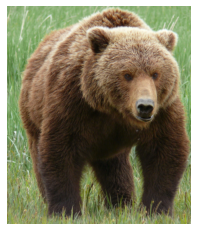

In [89]:
show_image(im.permute(1, 2, 0));

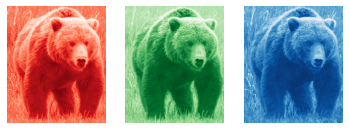

In [93]:
_, axs = plt.subplots(1, 3)
for bear, ax, color in zip(im, axs, ('Reds', 'Greens', 'Blues')):
    show_image(255-bear, ax=ax, cmap=color)

In [6]:
import nbdev; nbdev.nbdev_export()